## NLP Assignment-2 Part-1 Task-2
#### Name: Ishaan Sinha
#### Roll number: 21CS30064

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, TimeDistributed, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from matplotlib import pyplot

In [2]:
from datasets import load_dataset

# Load the full CNN/Daily Mail dataset (train split)
ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

# Check the size of the train dataset
total_size = len(ds['train'])
print(f"Total size of the dataset: {total_size}")

# Take a 10% sample of the dataset
sample_size = int(0.1 * total_size)  # Calculate 10% of the dataset
ds2 = ds['train'].shuffle(seed=42).select(range(sample_size))
# Check the size of the sampled dataset
total_sample_size = len(ds2)
print(f"Total size of the sampled dataset: {total_sample_size}")

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Total size of the dataset: 287113
Total size of the sampled dataset: 28711


In [3]:
# Convert the sampled dataset into a DataFrame with columns 'text' and 'summary'
df = pd.DataFrame({
    'text': ds2['article'],  # Use 'article' field for the text
    'summary': ds2['highlights']  # Use 'highlights' field for the summary
})

### Text Preprocessing

In [4]:
#Reducing the length of dataset by removing redundant data and missing values in order to increase the performance
df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(axis=0,inplace=True)

In [5]:
#Dictionary for expanding the contractions
Mapping_for_Contraction = {
    "he's": "he is", "you'll": "you will", "y'all'd": "you all would", "mightn't've": "might not have", "shan't": "shall not",
    "there'd": "there would", "i'd've": "i would have", "she'd": "she would", "you'd've": "you would have", "it'll": "it will",
    "couldn't": "could not", "it'd've": "it would have", "i've": "i have", "who's": "who is", "shan't've": "shall not have",
    "i'll": "i will", "won't": "will not", "i'm": "i am", "isn't": "is not", "wouldn't've": "would not have", "they'd've": "they would have",
    "who've": "who have", "she'll": "she will", "haven't": "have not", "she'll've": "she will have", "mightn't": "might not",
    "shouldn't've": "should not have", "we've": "we have", "where's": "where is", "what's": "what is", "they're": "they are",
    "oughtn't": "ought not", "needn't": "need not", "he'd": "he would", "weren't": "were not", "they've": "they have",
    "won't've": "will not have", "that'd": "that would", "i'd": "i would", "here's": "here is", "shouldn't": "should not",
    "you'd": "you would", "mayn't": "may not", "that'd've": "that would have", "when've": "when have", "she'd've": "she would have",
    "y'all've": "you all have", "you've": "you have", "you're": "you are", "let's": "let us", "they'll": "they will",
    "mustn't": "must not", "when's": "when is", "what'll": "what will", "who'll": "who will", "ain't": "is not", 
    "they'll've": "they will have", "so've": "so have", "you'll've": "you will have", "it'd": "it would", 
    "this's": "this is", "he'll": "he will", "we're": "we are", "mustn't've": "must not have", "here's": "here is",
    "to've": "to have", "why've": "why have", "how'd": "how did", "they'd": "they would", "could've": "could have",
    "o'clock": "of the clock", "ma'am": "madam", "doesn't": "does not", "we'd": "we would", "what've": "what have",
    "needn't've": "need not have", "hasn't": "has not", "so's": "so as", "can't": "cannot", "couldn't've": "could not have",
    "shalln't": "shall not", "they're": "they are", "you've": "you have", "won't": "will not", "didn't": "did not",
    "what're": "what are", "aren't": "are not", "where'd": "where did", "he'll've": "he will have", "what'll've": "what will have",
    "hadn't": "had not", "where've": "where have", "will've": "will have", "he'd've": "he would have", "she's": "she is",
    "it'll've": "it will have", "we'd've": "we would have", "'cause": "because", "we'll": "we will", "isn't": "is not",
    "how'll": "how will", "wouldn't": "would not", "shalln't": "shall not", "why's": "why is", "where've": "where have",
    "it'll've": "it will have", "y'all": "you all", "aren't": "are not", "he'll": "he will", "oughtn't've": "ought not have",
    "couldn't": "could not", "who'll've": "who will have", "y'all'd've": "you all would have", "how'd'y": "how do you",
    "you'd've": "you would have", "couldn't've": "could not have", "we'll've": "we will have", "how's": "how is",
    "didn't": "did not", "could've": "could have", "haven't": "have not", "where's": "where is", "he'll": "he will",
    "must've": "must have", "wasn't": "was not", "might've": "might have", "you've": "you have", "i'm": "i am",
    "there's": "there is", "y'all're": "you all are", "what's": "what is", "hadn't've": "had not have",
    "they've": "they have", "we'll": "we will", "they're": "they are", "couldn't": "could not", "he'll've": "he will have"
}


In [6]:
# Downloading stopwords from NLTK if not already downloaded
nltk.download('stopwords')

# Creating a set of stop words for filtering
stop_words = set(stopwords.words('english'))

def clean_text(text, include_stopwords=False):
    # Converting text to lowercase
    text = text.lower()
    
    # Parsing HTML content to extract plain text
    text = BeautifulSoup(text, "lxml").get_text()
    
    # Removing text within parentheses
    text = re.sub(r'\([^)]*\)', '', text)
    
    # Removing double quotes
    text = text.replace('"', '')
    
    # Expanding contractions
    text = ' '.join([Mapping_for_Contraction.get(word, word) for word in text.split()])
    
    # Removing possessives and other 's forms
    text = re.sub(r"\b's\b", '', text)
    
    # Removing non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Splitting text into tokens and filtering stop words if specified
    tokens = text.split()
    if not include_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Keeping only words with more than one character
    filtered_words = [token for token in tokens if len(token) > 1]
    
    # Joining the filtered tokens back into a cleaned string
    return ' '.join(filtered_words).strip()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#Text Cleaning
text_after_cleaning = []       #Using the clean_text function for cleaning text
for t in df['text']:
    text_after_cleaning.append(clean_text(t,0))

In [8]:
#Summary Cleaning 
summary_after_cleaning = []    #Using the clean_text function for cleaning summary as well
for t in df['summary']:
    summary_after_cleaning.append(clean_text(t,1))

/tmp/ipykernel_23/2588256555.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text()


In [9]:
df['Cleaned_Text'] = text_after_cleaning        #Adding text_after_cleaning to the dataset
df['Cleaned_Summary'] = summary_after_cleaning  #Adding summary_after_cleaning to the dataset
#Dropping off the Empty Rows
df['Cleaned_Summary'].replace('', np.nan, inplace=True)
#Dropping off the Rows with Missing values
df.dropna(axis=0,inplace=True)

/tmp/ipykernel_23/3080299025.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cleaned_Summary'].replace('', np.nan, inplace=True)


In [10]:
word_count_of_text = []
word_count_of_summary = []

#Populating the lists with sentence lengths
for i in df['Cleaned_Text']:
      word_count_of_text.append(len(i.split()))

for i in df['Cleaned_Summary']:
      word_count_of_summary.append(len(i.split()))

In [11]:
#Function for getting the Maximum Review length  
count=0 
for i in df['Cleaned_Text']:
    if(len(i.split())<=700):
        count=count+1
print(count/len(df['Cleaned_Text']))

0.9356998395982984


In [12]:
#Function for getting the Maximum Summary length
count=0
for i in df['Cleaned_Summary']:
    if(len(i.split())<=100):
        count=count+1
print(count/len(df['Cleaned_Summary']))

0.9840993095752842


In [13]:
#From the above data we got an idea about maximum lengths of review and summary
max_text_len = 700
max_summary_len = 100

In [14]:
#Adding START and END tags to summary for better decoding
text_after_cleaning = np.array(df['Cleaned_Text'])
summary_after_cleaning = np.array(df['Cleaned_Summary'])

short_text=[]
short_summary=[]

for i in range(len(text_after_cleaning)):
    if(len(summary_after_cleaning[i].split())<=max_summary_len and len(text_after_cleaning[i].split())<=max_text_len):
        short_text.append(text_after_cleaning[i])
        short_summary.append(summary_after_cleaning[i])
        
df2=pd.DataFrame({'text':short_text,'summary':short_summary})

In [15]:
df2['summary'] = df2['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [16]:
#Splitting the Dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(df2['text']),np.array(df2['summary']),test_size=0.2,random_state=0,shuffle=True)

### Building of seq2seq architecture without using Attention Layer 

In [17]:
#preparing a tokenizer for articles on training data
X_tokenizer = Tokenizer() 
X_tokenizer.fit_on_texts(list(X_train))

In [18]:
#Rarewords and their coverage in article
thresh = 4  #Words having count(or frequency) < 4 are considered as rare words

cnt = 0      #cnt denotes number of rare words
tot_cnt = 0  #denotes size of unique words in the text
freq = 0
tot_freq = 0

for key,value in X_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 53.19512981377241
Total Coverage of rare words: 1.3269349152011267


In [19]:
#Defining the Tokenizer with top most common words for articles
X_tokenizer = Tokenizer(num_words=tot_cnt-cnt)   #provides top most common words
X_tokenizer.fit_on_texts(list(X_train))

#Converting text sequences into integer sequences
X_train_seq    =   X_tokenizer.texts_to_sequences(X_train) 
X_test_seq   =   X_tokenizer.texts_to_sequences(X_test)

#Padding zero upto maximum length
X_train    =   pad_sequences(X_train_seq,  maxlen = max_text_len, padding = 'post')
X_test   =   pad_sequences(X_test_seq, maxlen = max_text_len, padding = 'post')

#Size of vocabulary (+1 for padding token)
X_voc   =  X_tokenizer.num_words + 1

In [20]:
#Preparing a Tokenizer for summaries on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [21]:
#Rarewords and their coverage in summary
thresh = 6  #Words having count(or frequency) < 6 are considered as rare words 

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        cnt = cnt+1
        freq = freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.87811524768142
Total Coverage of rare words: 6.159351909913529


In [22]:
#Defining Tokenizer with the most common words in summary
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)  #provides top most common words
y_tokenizer.fit_on_texts(list(y_train))

#Converting text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train)
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test)

#Padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [23]:
#Checking the length of training data
y_tokenizer.word_counts['sostok'],len(y_train)

(21211, 21211)

In [24]:
#Deleting rows containing only START and END tokens
#For Training set Summaries
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

In [25]:
#For Validation set Summaries
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

In [26]:
K.clear_session()

latent_dim = 256
embedding_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(X_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# Encoder LSTM 4
encoder_lstm4 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output4, state_h4, state_c4 = encoder_lstm4(encoder_output3)

# Encoder LSTM 5
encoder_lstm5 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm5(encoder_output4)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# Embedding layer for decoder
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer with softmax activation
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 700)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 700, 256)  │ 14,496,256 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 700,      │    525,312 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 700,      │    525,312 │ lstm[0][0]        │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 700,      │    525,312 │ lstm_1[0][0]      │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 700,      │    525,312 │ lstm_2[0][0]      │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  3,159,552 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 700,      │    525,312 │ lstm_3[0][0]      │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, None,     │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_4[0][1],     │
│                     │ 256), (None,      │            │ lstm_4[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  3,171,894 │ lstm_5[0][0]      │
│ (TimeDistributed)   │ 12342)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,979,574 (91.47 MB)

 Trainable params: 23,979,574 (91.47 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history = model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size= 128, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 158s 875ms/step - loss: 4.5558 - val_loss: 3.1034
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 887ms/step - loss: 3.1526 - val_loss: 3.0903
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 886ms/step - loss: 3.1250 - val_loss: 3.0871
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 887ms/step - loss: 3.1226 - val_loss: 3.0683
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 887ms/step - loss: 3.0810 - val_loss: 3.0456
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 886ms/step - loss: 3.0634 - val_loss: 3.0334
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 887ms/step - loss: 3.0525 - val_loss: 3.0174
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 887ms/step - loss: 3.0383 - val_loss: 3.0032
Epoch 9/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 886ms/step - loss: 3.0231 - val_loss: 2.9887
Epoch 10/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 886ms/step - loss: 3.0080 - val_loss: 2.9675
Epoch 11/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 203s 889ms/step - loss: 2.9854 - val_loss: 2.9509
Epoch 12

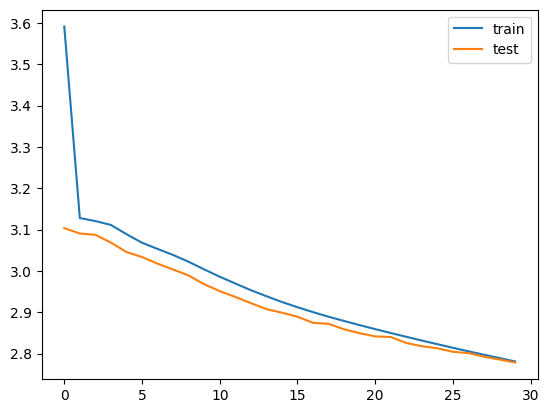

In [28]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=X_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [30]:
# Encoding our input seq for feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 

# initial states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# softmax for probability
decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # sampled_token = reverse_target_word_index[sampled_token_index]
        # Check if the sampled token index is in the vocabulary
        if sampled_token_index in reverse_target_word_index:
            sampled_token = reverse_target_word_index[sampled_token_index]
        else:
            sampled_token = '<unk>'  # or handle it however you prefer
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [32]:
def sequence_to_summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def sequence_to_text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [33]:
for i in range(0,10):
    print("Review:",sequence_to_text(X_train[i]))
    print("Original summary:",(sequence_to_summary(y_train[i])).replace('start', '').replace('end', ''))
    print("Predicted summary:",(decode_sequence(X_train[i].reshape(1,max_text_len))).replace('start', '').replace('end', ''))
    print("\n")

Review: jill reilly photographer shared stunning gallery african sunrises sunsets paul goldstein says spent years trying photograph perfect beginning ending masai mara day thanks role travel guide countless opportunities document beautiful natural spectacle photographer shared stunning gallery african sunrises sunsets pictured black bellied sunset paul goldstein says spent years trying photograph perfect beginning ending masai mara day thanks role travel guide countless opportunities document beautiful natural spectacle mr goldstein wimbledon explains thousands images taken sunrise sunset around world per cent two mara conservancies kenya mara north masai mara well known best photographic light world well managed conservancies also best spots sunrise sunset without crowds people said mr goldstein wimbledon explains thousands images taken sunrise sunset around world per cent two mara conservancies kenya mara north masai mara well known best photographic light world well managed conserva

In [34]:
!pip install rouge-score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=094156659f3ccd071a1145ed2ef50309d655765e3cc2056eedefd015e8b11dc8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [35]:
from rouge_score import rouge_scorer

def calculate_rouge_scores(N=20):
    rouge_2 = 0
    rouge_l = 0
    
    # Initialize the ROUGE scorer for ROUGE-2 and ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rouge2', 'rougeL'], use_stemmer=True)

    for i in range(N):
        ref = sequence_to_summary(y_test[i])  # Reference summary
        hypo = decode_sequence(X_test[i].reshape(1, max_text_len))  # Hypothesis generated summary

        # Compute the ROUGE scores
        scores = scorer.score(ref, hypo)

        # Accumulate ROUGE-2 and ROUGE-L F1 scores
        rouge_2 += scores['rouge2'].fmeasure
        rouge_l += scores['rougeL'].fmeasure

    # Average the scores over N examples
    rouge_2_avg = rouge_2 / N
    rouge_l_avg = rouge_l / N
    
    print("ROUGE-2:%.4f ROUGE-L:%.4f" % (rouge_2_avg, rouge_l_avg))

# Call the function to calculate the ROUGE scores
calculate_rouge_scores()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━